In [17]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

<Figure size 432x288 with 0 Axes>

In [2]:
data = pd.read_csv("../datasets/apple/AAPL.csv")[::-1]
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
3088,2017-04-07,143.729996,144.179993,143.270004,143.339996,140.565704,16672200
3087,2017-04-06,144.289993,144.520004,143.449997,143.660004,140.879517,21149000
3086,2017-04-05,144.220001,145.460007,143.809998,144.020004,141.232559,27717900
3085,2017-04-04,143.250000,144.889999,143.169998,144.770004,141.968033,19891400
3084,2017-04-03,143.710007,144.119995,143.050003,143.699997,140.918762,19985700


In [3]:
openp = data.loc[:, 'Open'].tolist()
highp = data.loc[:, 'High'].tolist()
lowp = data.loc[:, 'Low'].tolist()
closep = data.loc[:, 'Adj Close'].tolist()
volumep = data.loc[:, 'Volume'].tolist()

In [4]:
WINDOW = 30
EMB_SIZE = 5
STEP = 1
FORECAST = 1

In [5]:
X, Y = [], []
for i in range(0, len(data), STEP):
    try:
        o = openp[i: i + WINDOW]
        h = highp[i: i + WINDOW]
        l = lowp[i: i + WINDOW]
        c = closep[i: i + WINDOW]
        v = volumep[i: i+ WINDOW]
        
        o = (np.array(o) - np.mean(o)) / np.std(o)
        h = (np.array(h) - np.mean(h)) / np.std(h)
        l = (np.array(l) - np.mean(l)) / np.std(l)
        c = (np.array(c) - np.mean(c)) / np.std(c)
        v = (np.array(v) - np.mean(v)) / np.std(v)
        
        x_i = closep[i: i + WINDOW]
        y_i = closep[i + WINDOW + FORECAST]
        
        last_close = x_i[-1]
        next_close = y_i
        
        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1]
            
        x_i = np.column_stack((o, h, l, c, v))
    except Exception as e:
        print(str(e))
        break
        
    X.append(x_i)
    Y.append(y_i)

list index out of range


In [6]:
from preprocessing import shuffle_in_unison, create_Xt_Yt

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [7]:
print(X.shape)
print(Y.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3058, 30, 5)
(3058, 2)
(2446, 30, 5)
(2446, 2)
(612, 30, 5)
(612, 2)


In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

In [9]:
print(X.shape)
print(Y.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3058, 30, 5)
(3058, 2)
(2446, 30, 5)
(2446, 2)
(612, 30, 5)
(612, 2)


In [10]:
def build():
    model = Sequential()
    model.add(Convolution1D(
        input_shape=(WINDOW, EMB_SIZE),
        nb_filter=16,
        filter_length=4,
        border_mode='same'
    ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    opt = Nadam(lr=0.002)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    

In [15]:
model = build()
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint('output/lolkek.hdf5', verbose=1, save_best_only=True)

H = model.fit(X_train, Y_train, epochs=100, batch_size=128, verbose=1, validation_data=(X_test, Y_test),
    callbacks=[reduce_lr, checkpointer], shuffle=True)

/anaconda3/envs/dlcv/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(30, 5), filters=16, kernel_size=4, padding="same")`
  import sys


Train on 2446 samples, validate on 612 samples
Epoch 1/100
2446/2446 [==============================] - 1s 442us/step - loss: 0.7972 - acc: 0.5282 - val_loss: 0.6888 - val_acc: 0.5441

Epoch 00001: val_loss improved from inf to 0.68882, saving model to output/lolkek.hdf5
Epoch 2/100
2446/2446 [==============================] - 0s 140us/step - loss: 0.7437 - acc: 0.5458 - val_loss: 0.6827 - val_acc: 0.5605

Epoch 00002: val_loss improved from 0.68882 to 0.68267, saving model to output/lolkek.hdf5
Epoch 3/100
2446/2446 [==============================] - 0s 143us/step - loss: 0.7267 - acc: 0.5462 - val_loss: 0.6922 - val_acc: 0.5229

Epoch 00003: val_loss did not improve
Epoch 4/100
2446/2446 [==============================] - 0s 142us/step - loss: 0.6950 - acc: 0.5703 - val_loss: 0.6774 - val_acc: 0.5850

Epoch 00004: val_loss improved from 0.68267 to 0.67739, saving model to output/lolkek.hdf5
Epoch 5/100
2446/2446 [==============================] - 0s 142us/step - loss: 0.6922 - acc: 0

In [13]:
model.load_weights("output/lolkek.hdf5")
pred = model.predict(np.array(X_test))

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])
print(C/C.astype(np.float).sum(axis=1))

[[0.4962963  0.39766082]
 [0.25555556 0.79824561]]


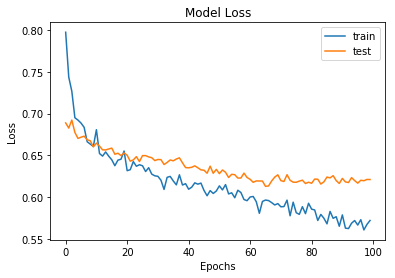

In [18]:
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='best')
plt.show()

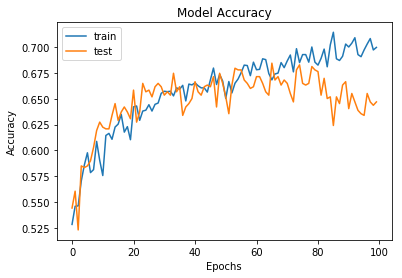

In [19]:
plt.figure()
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
x = [1, 2, 3, 4, 5]
y = [11, 12, 13, 14, 15]
z = [21, 22, 23, 24, 25]

a = np.column_stack((x, y, z))
print(a)